# Braking Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

## 1 Data

In [2]:
import pandas as pd
decel_set = pd.read_csv("data/3-braking/decel_set.csv")

In [241]:
decel_set.shape[0]

22806

In [242]:
decel_set[decel_set['braking'] == 1].shape[0]

11479

In [243]:
decel_set[decel_set['braking'] == 1].shape[0] / decel_set.shape[0]

0.5033324563711304

## 2 Methods

### 2.1 Coastdown Curve

In [4]:
# Coast down curve params for LDV from MOVES3.0
# y = -0.0001454 * x2 + 0.0000622 * x - O.1758­ (mph)
A = -0.0001454 / (1.609344 ** 2) / 3.6 * 1.609344
B = 0.0000622 / 1.609344 / 3.6 * 1.609344
C = -0.1758 / 3.6 * 1.609344

def coastDownDec(v):
    """
    Coasting deceleration value calculation according to the coast-down curve of 1497kg vehicles.
    v: speed, km/h
    return: dec, m/s^2
    """
    dec = A * v**2 + B * v + C
    return np.float32(dec)

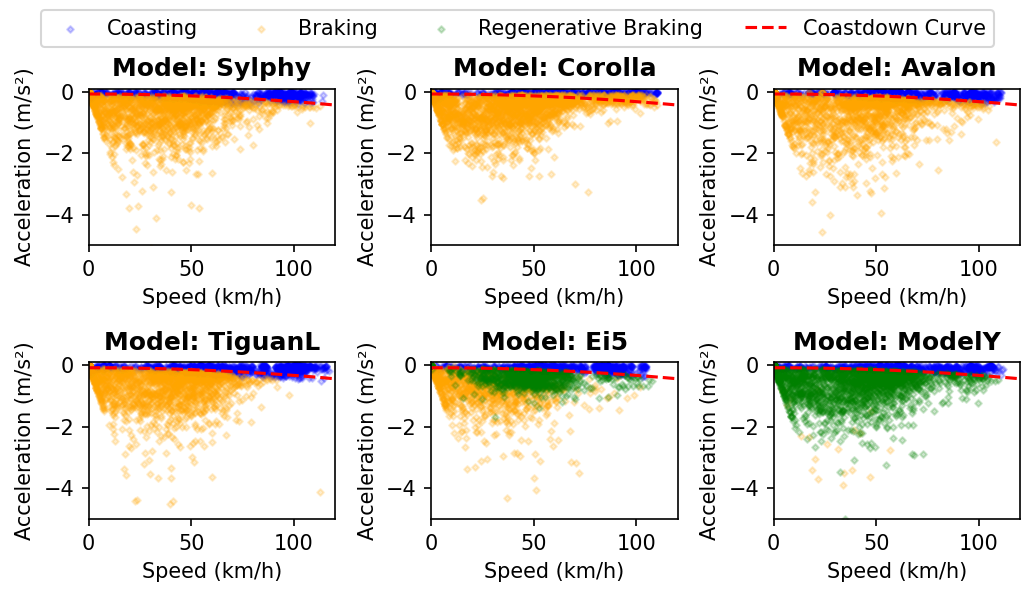

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(7,4))
axes = axes.flatten()

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    deceleration_data = model_data[(model_data['braking'] == 0)]
    braking_data = model_data[(model_data['braking'] == 1) & (model_data['reg'] == 0)]
    reg_data = model_data[(model_data['braking'] == 1) & (model_data['reg'] == 1)]

    # points
    decel_scatter = axes[i].scatter(deceleration_data['speed[km/h]'], deceleration_data['acc[m/s2]'],
                                marker='D', alpha=0.2, c='blue', label='Coasting', s=5)    
    brake_scatter = axes[i].scatter(braking_data['speed[km/h]'], braking_data['acc[m/s2]'],
                                    marker='D', alpha=0.2, c='orange', label='Braking', s=5)
    reg_scatter = axes[i].scatter(reg_data['speed[km/h]'], reg_data['acc[m/s2]'],
                                  marker='D', alpha=0.2, c='green', label='Regenerative Braking', s=5)
    # coastdown curve
    speeds = np.linspace(0, 120, 100)
    decelerations = coastDownDec(speeds)
    axes[i].plot(speeds, decelerations, 'r--', label='Coastdown Curve')

    axes[i].set_title(f'Model: {model}', fontweight='bold')
    axes[i].set_xlabel('Speed (km/h)')
    axes[i].set_ylabel('Acceleration (m/s²)')
    axes[i].set_xlim(0,120)
    axes[i].set_ylim(-5,0.1)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2.2 Machine learning

In [17]:
import warnings
warnings.filterwarnings("ignore")

import joblib

#### Dataset

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

X = decel_set[['speed[km/h]', 'acc[m/s2]']]
y = decel_set['braking']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, decel_set['model']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"train size: {len(X_train)}")
print(f"test size: {len(X_test)}")

train_model_counts = decel_set.iloc[train_index]['model'].value_counts(normalize=True)
test_model_counts = decel_set.iloc[test_index]['model'].value_counts(normalize=True)
print("train proportion of each model:")
print(train_model_counts)
print("test proportion of each model:")
print(test_model_counts)

train size: 15964
test size: 6842
train proportion of each model:
model
Corolla    0.182473
ModelY     0.171260
Sylphy     0.169256
TiguanL    0.167565
Ei5        0.161927
Avalon     0.147519
Name: proportion, dtype: float64
test proportion of each model:
model
Corolla    0.182403
ModelY     0.171295
Sylphy     0.169249
TiguanL    0.167495
Ei5        0.161941
Avalon     0.147618
Name: proportion, dtype: float64


In [ ]:
# np.save('data/3-braking/detection/train_index.npy', train_index)
# np.save('data/3-braking/detection/test_index.npy', test_index)

#### Training

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score

def train_and_evaluate_model(X, y, model, params:dict, fold=5):
    """
    Train and evaluate model.
    """
    # train
    kfold = KFold(n_splits=fold, shuffle=True, random_state=42)
    scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, params, cv=kfold, scoring=scorer)
    grid_search.fit(X, y)
    # output
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    return best_model, best_params, best_score

Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
logistic_regression_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
best_LR, best_LR_params, best_LR_acc = train_and_evaluate_model(X_train, y_train, LogisticRegression(), logistic_regression_param_grid, fold=5)
print(best_LR_params, best_LR_acc)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 0.9045351595399398


In [30]:
joblib.dump(best_LR, "data/3-braking/detection/LR.joblib")

['data/3-braking/detection/LR.joblib']

SVM

In [31]:
from sklearn.svm import SVC
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}
best_SVM, best_SVM_params, best_SVM_acc = train_and_evaluate_model(X_train, y_train, SVC(), svm_param_grid, fold=5)
print(best_SVM_params, best_SVM_acc)

{'C': 1, 'kernel': 'linear'} 0.9038460149748


In [32]:
joblib.dump(best_SVM, "data/3-braking/detection/SVM.joblib")

['data/3-braking/detection/SVM.joblib']

Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_param_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
best_DT, best_DT_params, best_DT_acc = train_and_evaluate_model(X_train, y_train, DecisionTreeClassifier(), decision_tree_param_grid, fold=5)
print(best_DT_params, best_DT_acc)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10} 0.9054746363246042


In [34]:
joblib.dump(best_DT, "data/3-braking/detection/DT.joblib")

['data/3-braking/detection/DT.joblib']

Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
random_forest_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 9],
}
best_RF, best_RF_params, best_RF_acc = train_and_evaluate_model(X_train, y_train, RandomForestClassifier(), random_forest_param_grid, fold=5)
print(best_RF_params, best_RF_acc)

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 150} 0.9072912472223467


In [36]:
joblib.dump(best_RF, "data/3-braking/detection/RF.joblib")

['data/3-braking/detection/RF.joblib']

KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}
best_KNN, best_KNN_params, best_KNN_acc = train_and_evaluate_model(X_train, y_train, KNeighborsClassifier(), knn_param_grid, fold=5)
print(best_KNN_params, best_KNN_acc)

{'metric': 'manhattan', 'n_neighbors': 7} 0.8811071289247232


In [38]:
joblib.dump(best_KNN, "data/3-braking/detection/KNN.joblib")

['data/3-braking/detection/KNN.joblib']

## 3 Evaluation

In [ ]:
def coastdown_braking_detect(v,a):
    return 1 if a < coastDownDec(v) else 0
decel_set['braking_CD'] = decel_set.apply(lambda x: coastdown_braking_detect(x['speed[km/h]'], x['acc[m/s2]']), axis=1)

In [ ]:
decel_set['braking_LR'] = best_LR.predict(decel_set[['speed[km/h]','acc[m/s2]']])
decel_set['braking_SVM'] = best_SVM.predict(decel_set[['speed[km/h]','acc[m/s2]']])
decel_set['braking_KNN'] = best_KNN.predict(decel_set[['speed[km/h]','acc[m/s2]']])
decel_set['braking_DT'] = best_DT.predict(decel_set[['speed[km/h]','acc[m/s2]']])
decel_set['braking_RF'] = best_RF.predict(decel_set[['speed[km/h]','acc[m/s2]']])

In [ ]:
decel_set['braking_TH0'] = decel_set['acc[m/s2]'].apply(lambda x: 1 if x < 0 else 0)
decel_set['braking_TH05'] = decel_set['acc[m/s2]'].apply(lambda x: 1 if x < -0.5 else 0)

In [316]:
decel_set.to_csv("data/3-braking/detection/decel_set_detected.csv", index=False)

### precision, recall, f1

In [263]:
# test set
test_set = decel_set.iloc[test_index]
models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
test_set['model'] = pd.Categorical(test_set['model'], categories=models, ordered=True)
test_set = test_set.sort_values(by='model')
test_set.reset_index(inplace=True, drop=True)

In [265]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
predCols = ['braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF', 'braking_TH0', 'braking_TH05']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']
trueCol = 'braking'

results = []

for predCol, colName in zip(predCols, colNames):
    for model in models:
        group = test_set[test_set['model'] == model]
        true_values = group[trueCol]
        predicted_values = group[predCol]
        precision = precision_score(true_values, predicted_values)
        recall = recall_score(true_values, predicted_values)
        f1 = f1_score(true_values, predicted_values)
        accuracy = accuracy_score(true_values, predicted_values)
        results.append({
            'model': model,
            'prediction_method': colName,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy
        })

score = pd.DataFrame(results)

In [266]:
score.iloc[:,1:].groupby(by='prediction_method').mean()

,precision,recall,f1_score,accuracy
prediction_method,,,,
KNN,0.934374,0.834691,0.880246,0.886128
SVM,0.958151,0.854493,0.902040,0.906979
coastdown curve,0.925475,0.873606,0.897430,0.900371
decision tree,0.952704,0.858485,0.901606,0.906329
logistic regression,0.957500,0.854988,0.902025,0.906933
random forest,0.961515,0.856516,0.904431,0.909440
threshold=-0.5,1.000000,0.460989,0.630288,0.728551
threshold=0,0.501281,1.000000,0.666907,0.501281


In [270]:
score[~(score['prediction_method'].isin(['threshold=0', 'threshold=-0.5']))][['model', 'precision', 'recall', 'f1_score']].groupby(by='model').mean()

,precision,recall,f1_score
model,,,
Avalon,0.957003,0.872825,0.912869
Corolla,0.984700,0.755524,0.854904
Ei5,0.967842,0.889373,0.926820
ModelY,0.965460,0.849338,0.903575
Sylphy,0.902110,0.866110,0.883623
TiguanL,0.912604,0.899610,0.905987


In [ ]:
# score.to_csv("data/3-braking/detection/score.csv", index=False)

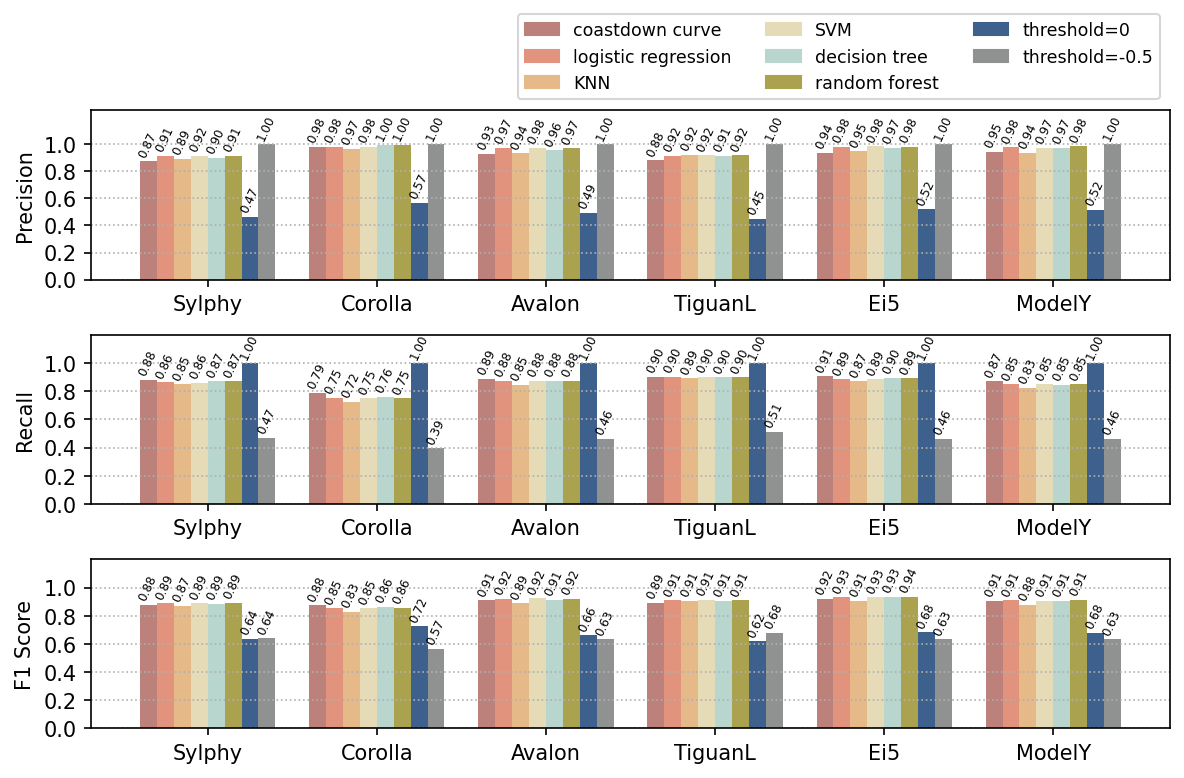

In [273]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']
trueCol = 'braking'
colors = ['#BB817A', '#E1937D', '#E6B988', '#E5DBB6', '#B9D6CE', '#AAA24F', '#3E608D', '#909291']

fig, axes = plt.subplots(3, 1, figsize=(8,5))

width = 0.1
x = np.arange(len(models))

# precision
for i, colName in enumerate(colNames):
    precision = score[score['prediction_method'] == colName]['precision']
    bars = axes[0].bar(x + i * width, precision, width, label=colName, color=colors[i])
    axes[0].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[0].set_ylim(0,1.25)
axes[0].set_ylabel('Precision')
axes[0].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[0].set_yticks(np.arange(0, 1.1, 0.2))
axes[0].set_xticklabels(models)
axes[0].grid(axis='y', linestyle=":")

# recall
for i, colName in enumerate(colNames):
    recall = score[score['prediction_method'] == colName]['recall']
    bars = axes[1].bar(x + i * width, recall, width, label=colName, color=colors[i])
    axes[1].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[1].set_ylim(0,1.2)
axes[1].set_ylabel('Recall')
axes[1].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[1].set_yticks(np.arange(0, 1.1, 0.2))
axes[1].set_xticklabels(models)
axes[1].grid(axis='y', linestyle=":")

# f1 score
for i, colName in enumerate(colNames):
    f1_score = score[score['prediction_method'] == colName]['f1_score']
    bars = axes[2].bar(x + i * width, f1_score, width, label=colName, color=colors[i])
    axes[2].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[2].set_ylim(0,1.2)
axes[2].set_ylabel('F1 Score')
axes[2].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[2].set_yticks(np.arange(0, 1.1, 0.2))
axes[2].set_xticklabels(models)
axes[2].grid(axis='y', linestyle=":")

# legend
legend_elements = [Patch(facecolor=color, edgecolor=color, label=colName) for color, colName in zip(colors, colNames)]
fig.legend(handles=legend_elements, fontsize='small', ncols=3, bbox_to_anchor=(0.98, 1.04), bbox_transform=fig.transFigure)

# layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Distribution

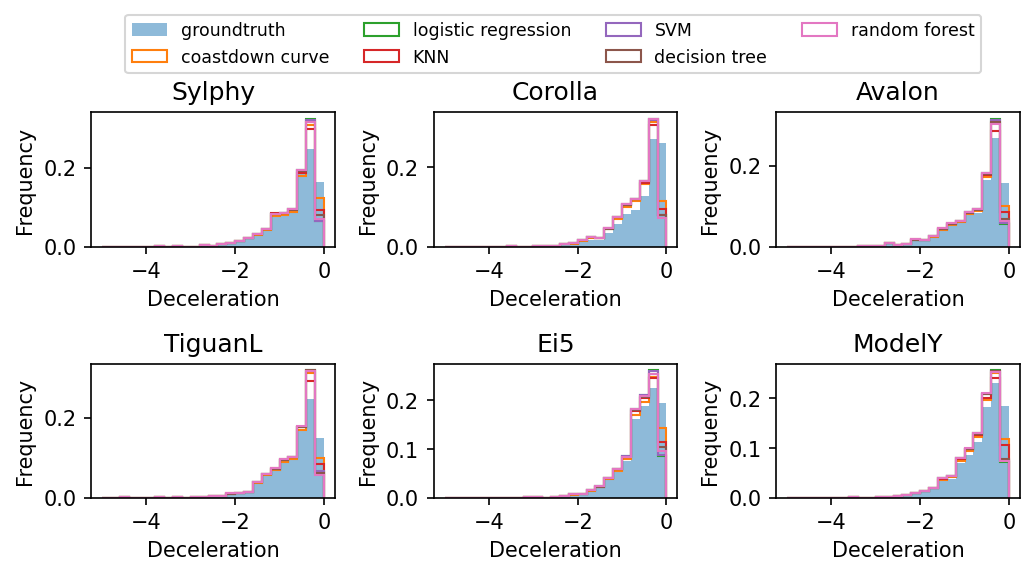

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
predCols = ['braking', 'braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF']
colNames = ['groundtruth', 'coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest']

fig, axes = plt.subplots(2, 3, figsize=(7,3.5))
axes = axes.flatten()

acc_bins = list(np.arange(-5,0.1,0.2))

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    
    for col, col_name in zip(predCols, colNames):
        data = model_data[model_data[col] == 1]['acc[m/s2]']
        num_data_points = len(data)
        weights = [1 / num_data_points] * num_data_points
        if col == 'braking':
            axes[i].hist(data, bins=acc_bins, weights=weights, histtype='stepfilled', alpha=0.5, label=col_name)
        else:
            axes[i].hist(data, bins=acc_bins, weights=weights, histtype='step', cumulative=False, label=col_name)
    
    axes[i].set_title(f'{model}')
    axes[i].set_xlabel('Deceleration')
    axes[i].set_ylabel('Frequency')

# legend
handles = []
labels = []
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize='small', ncols=4, bbox_to_anchor=(0.95, 1.1), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.show()

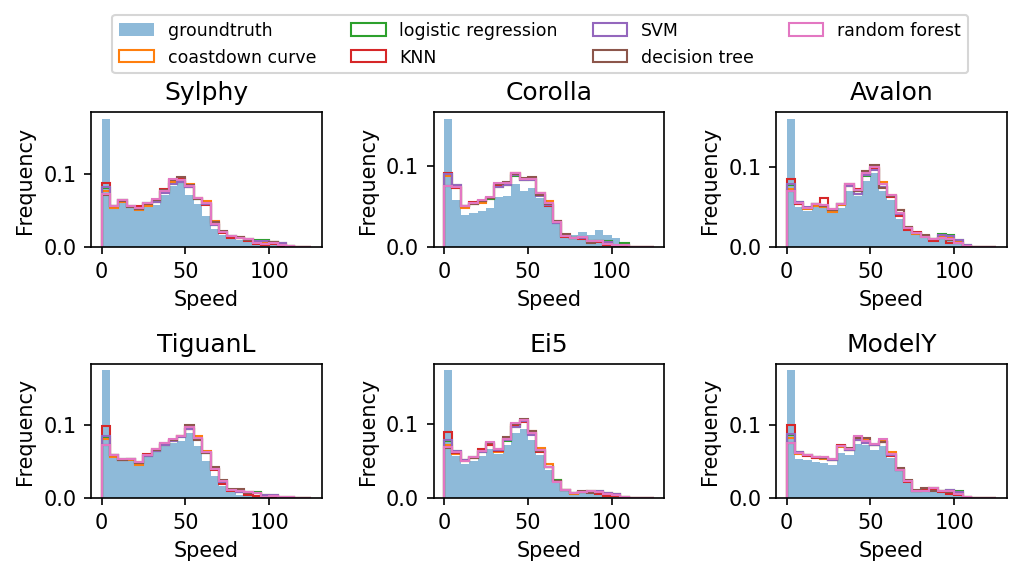

In [310]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
predCols = ['braking', 'braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF']
colNames = ['groundtruth', 'coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest']

fig, axes = plt.subplots(2, 3, figsize=(7,3.5))
axes = axes.flatten()

speed_bins = list(range(0,130,5))

for i, model in enumerate(models):
    model_data = decel_set[decel_set['model'] == model]
    
    for col, col_name in zip(predCols, colNames):
        data = model_data[model_data[col] == 1]['speed[km/h]']
        num_data_points = len(data)
        weights = [1 / num_data_points] * num_data_points
        if col == 'braking':
            axes[i].hist(data, bins=speed_bins, weights=weights, histtype='stepfilled', alpha=0.5, label=col_name)
        else:
            axes[i].hist(data, bins=speed_bins, weights=weights, histtype='step', cumulative=False, label=col_name)
    
    axes[i].set_title(f'{model}')
    axes[i].set_xlabel('Speed')
    axes[i].set_ylabel('Frequency')

# legend
handles = []
labels = []
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize='small', ncols=4, bbox_to_anchor=(0.95, 1.1), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.show()

Cross entropy

In [311]:
import pandas as pd
import numpy as np

def cross_entropy(p, q):
    epsilon = 1e-10
    q = np.maximum(q, epsilon)
    return -np.sum(p * np.log(q))

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
predCols = ['braking_CD', 'braking_LR', 'braking_KNN', 'braking_SVM', 'braking_DT', 'braking_RF', 'braking_TH0', 'braking_TH05']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']

results = []
speed_bins = list(range(0,130,5))
acc_bins = list(np.arange(-5,0.1,0.2))

for model in models:
    # true dist
    model_data = decel_set[decel_set['model'] == model]
    true_braking_acc = model_data[model_data['braking'] == 1]['acc[m/s2]']
    true_braking_speed = model_data[model_data['braking'] == 1]['speed[km/h]']
    true_hist_acc, _ = np.histogram(true_braking_acc, bins=acc_bins)
    true_hist_speed, _ = np.histogram(true_braking_speed, bins=speed_bins)
    true_freq_acc = true_hist_acc / true_hist_acc.sum()
    true_freq_speed = true_hist_speed / true_hist_speed.sum()

    # predict dist
    for predCol, colName in zip(predCols, colNames):
        pred_braking_acc = model_data[model_data[predCol] == 1]['acc[m/s2]']
        pred_braking_speed = model_data[model_data[predCol] == 1]['speed[km/h]']
        pred_hist_acc, _ = np.histogram(pred_braking_acc, bins=acc_bins)
        pred_hist_speed, _ = np.histogram(pred_braking_speed, bins=speed_bins)
        pred_freq_acc = pred_hist_acc / pred_hist_acc.sum()
        pred_freq_speed = pred_hist_speed / pred_hist_speed.sum()

        # entropy
        ce_acc = cross_entropy(true_freq_acc, pred_freq_acc)
        ce_speed = cross_entropy(true_freq_speed, pred_freq_speed)

        results.append({
            'model': model,
            'prediction_method': colName,
            'cross_entropy_acc': ce_acc,
            'cross_entropy_speed': ce_speed,
        })

entropy_df = pd.DataFrame(results)

# sort
models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
entropy_df['model'] = pd.Categorical(entropy_df['model'], categories=models, ordered=True)
entropy_df = entropy_df.sort_values(by='model')
entropy_df.reset_index(inplace=True, drop=True)

In [312]:
entropy_df.to_csv("data/3-braking/detection/entropy.csv", index=False)

In [313]:
entropy_df.iloc[:, 1:].groupby(by='prediction_method').mean()

,cross_entropy_acc,cross_entropy_speed
prediction_method,,
KNN,2.156056,2.813814
SVM,2.186458,2.798237
coastdown curve,2.139178,2.805094
decision tree,2.176985,2.814159
logistic regression,2.188006,2.799932
random forest,2.187669,2.812392
threshold=-0.5,11.211096,2.976790
threshold=0,2.427547,2.900268


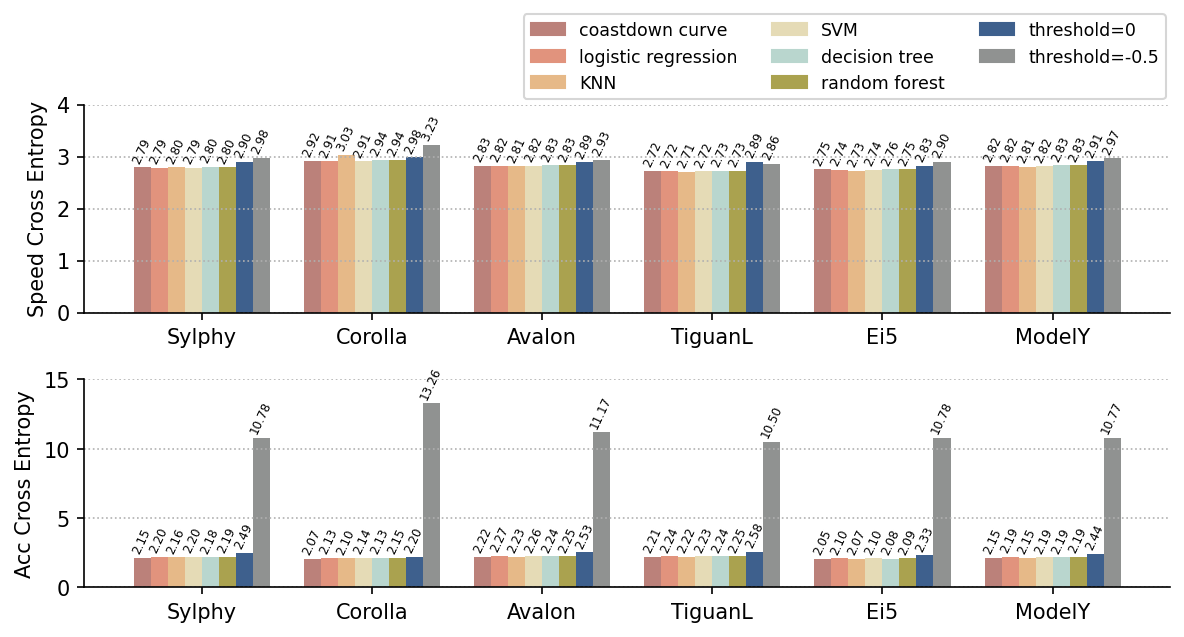

In [315]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
colNames = ['coastdown curve', 'logistic regression', 'KNN', 'SVM', 'decision tree', 'random forest', 'threshold=0', 'threshold=-0.5']
colors = ['#BB817A', '#E1937D', '#E6B988', '#E5DBB6', '#B9D6CE', '#AAA24F', '#3E608D', '#909291']

fig, axes = plt.subplots(2, 1, figsize=(8, 4))

width = 0.1
x = np.arange(len(models))

# speed entropy
for i, colName in enumerate(colNames):
    result = entropy_df[entropy_df['prediction_method'] == colName]['cross_entropy_speed']
    bars = axes[0].bar(x + i * width, result, width, label=colNames[i], color=colors[i])
    axes[0].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[0].set_ylabel('Speed Cross Entropy')
axes[0].set_ylim(0,4)
axes[0].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[0].set_xticklabels(models)
axes[0].grid(axis='y', linestyle=":")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# acc entropy
for i, colName in enumerate(colNames):
    result = entropy_df[entropy_df['prediction_method'] == colName]['cross_entropy_acc']
    bars = axes[1].bar(x + i * width, result, width, label=colNames[i], color=colors[i])
    axes[1].bar_label(bars, padding=1, fmt='%.2f', rotation=65, fontsize='xx-small')
axes[1].set_ylabel('Acc Cross Entropy')
axes[1].set_ylim(0,15)
axes[1].set_xticks(x + width * (len(colNames) - 1) / 2)
axes[1].set_xticklabels(models)
axes[1].grid(axis='y', linestyle=":")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# legend
legend_elements = [Patch(facecolor=color, edgecolor=color, label=colName) for color, colName in zip(colors, colNames)]
fig.legend(handles=legend_elements, fontsize='small', ncols=3, bbox_to_anchor=(0.985, 1.065), bbox_transform=fig.transFigure)

# layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()